In [1]:
import numpy as np
import pandas as pd
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from sklearn.metrics import f1_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import string
from textblob import TextBlob
import warnings



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
warnings.simplefilter('ignore')
scaler = torch.cuda.amp.GradScaler() 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

## Data Loading & Exploratory Data Analysis (EDA)

In [3]:
# Load the datasets
train_data = pd.read_csv('/kaggle/input/world-championship-2023-risk-evaluation/train_data.csv')
test_data = pd.read_csv('/kaggle/input/world-championship-2023-risk-evaluation/test_data_post.csv')
# Verifying the first few rows of the datasets
train_data.head()

,Tweets,Risk Analysis
0,interested in a job in epping nh this could be...,0.0
1,community violence cv is a public health epide...,1.0
2,cvs took a step that shows it s gearing up to ...,0.0
3,this job is now open at cvs health in henderso...,0.0
4,at cvs health we are committed to empowering m...,0.0


In [4]:
test_data.head()

,ID,Tweets
0,1,knowing what s right for you and your body isn...
1,2,looks like we need to boycott walmart exxonmob...
2,3,#cvshealth says of its employees are racially ...
3,4,be a part of cvshealth on our journey to trans...
4,5,juddlegum ford walmart delta deloitte nrcc lib...


In [5]:
# Display basic information about the training data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20204 entries, 0 to 20203
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Tweets         20204 non-null  object 
 1   Risk Analysis  20204 non-null  float64
dtypes: float64(1), object(1)
memory usage: 315.8+ KB


In [6]:
# Display basic information about the test data
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5052 entries, 0 to 5051
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      5052 non-null   int64 
 1   Tweets  5052 non-null   object
dtypes: int64(1), object(1)
memory usage: 79.1+ KB


## Distribution & statistical analysis

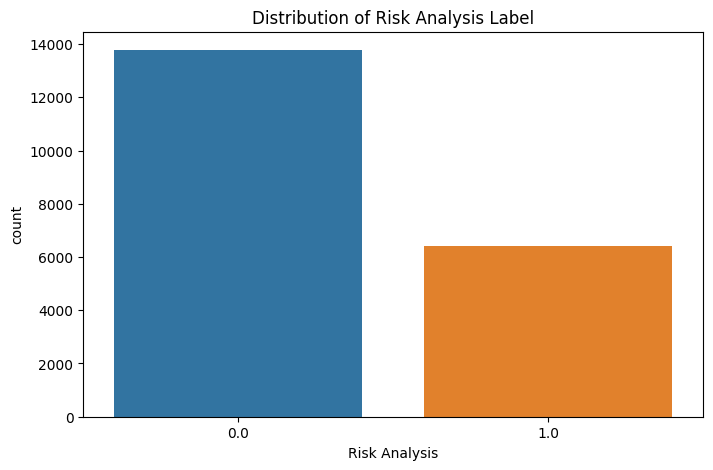

In [7]:
# Distribution of the 'Risk Analysis' label
plt.figure(figsize=(8, 5))
sns.countplot(data=train_data, x='Risk Analysis')
plt.title("Distribution of Risk Analysis Label")
plt.show()

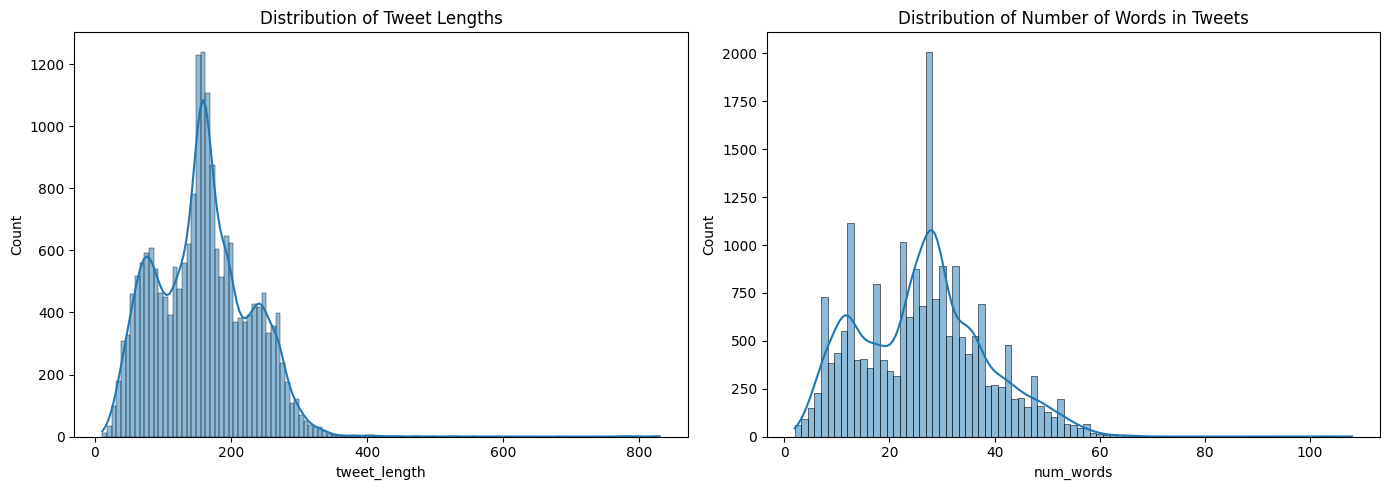

In [8]:
# Derive features from the text for EDA
train_data['tweet_length'] = train_data['Tweets'].apply(len)
train_data['num_words'] = train_data['Tweets'].apply(lambda x: len(x.split()))

# Distribution of tweet lengths
plt.figure(figsize=(14, 5))

# Tweet length distribution
plt.subplot(1, 2, 1)
sns.histplot(train_data['tweet_length'], kde=True)
plt.title("Distribution of Tweet Lengths")

# Number of words distribution
plt.subplot(1, 2, 2)
sns.histplot(train_data['num_words'], kde=True)
plt.title("Distribution of Number of Words in Tweets")

plt.tight_layout()
plt.show()


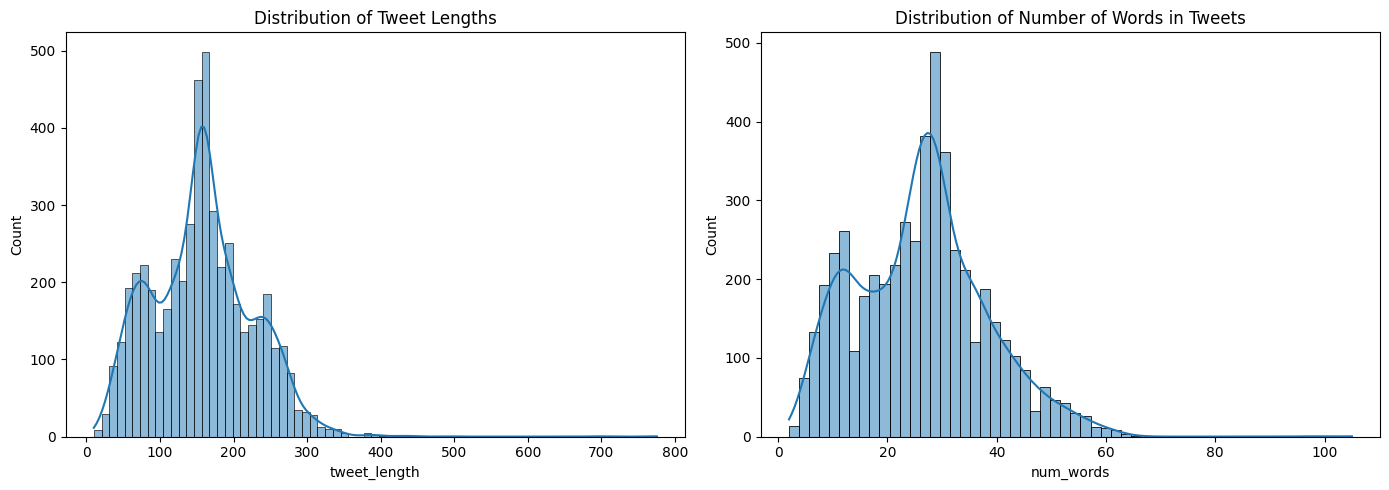

In [9]:
# Derive features from the text for EDA
test_data['tweet_length'] = test_data['Tweets'].apply(len)
test_data['num_words'] = test_data['Tweets'].apply(lambda x: len(x.split()))

# Distribution of tweet lengths
plt.figure(figsize=(14, 5))

# Tweet length distribution
plt.subplot(1, 2, 1)
sns.histplot(test_data['tweet_length'], kde=True)
plt.title("Distribution of Tweet Lengths")

# Number of words distribution
plt.subplot(1, 2, 2)
sns.histplot(test_data['num_words'], kde=True)
plt.title("Distribution of Number of Words in Tweets")

plt.tight_layout()
plt.show()


## EDA findings

Based on the exploratory visualizations, the following conclusions can be drawn:

**Distribution of Tweet Lengths:**

* The average length of a tweet is between 0 and 300 characters. 
* Only a small number of tweets exceed 300 characters, but these are relatively rare.

**Distribution of Number of Words in Tweets:**

* Tweets typically contain 0 to 60 words.
* After 60 words, the distribution sharply declines, which indicates that tweets that are very lengthy are less prevalent.

We can use these distributions to determine the maximum sequence length for tokenization when preprocessing text for model training.

## **Text Preprocessing phase**

We'll:

* Convert the text to lowercase.
* Remove URLs, mentions, and other unnecessary characters.
* Tokenize the text (this step will be integrated into the data loading process for the model).

In [10]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|\#\w+', '', text)
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove unnecessary white spaces
    text = text.strip()
    
    return text

train_data['cleaned_tweets'] = train_data['Tweets'].apply(preprocess_text)
test_data['cleaned_tweets'] = test_data['Tweets'].apply(preprocess_text)

# Display sample of cleaned tweets
train_data[['Tweets', 'cleaned_tweets']].sample(5)

,Tweets,cleaned_tweets
15236,cvs health corp cvs surprised the market with ...,cvs health corp cvs surprised the market with ...
3131,at cvs health we strive to take an active supp...,at cvs health we strive to take an active supp...
14191,thefaeriehouse cvshealth cvs is the worst,thefaeriehouse cvshealth cvs is the worst
13534,aaronicabcole usps cvshealth walgreens fedex ...,aaronicabcole usps cvshealth walgreens fedex o...
5729,this pharmacy technician retail store job migh...,this pharmacy technician retail store job migh...


## Feature engineering

Next, we will proceed to the **Feature Engineering phase**. We will:

From the text, extract tabular features, such as word length, word count, and sentiment scores (if applicable).

In [11]:
# Extracting sentiment scores using TextBlob
train_data['sentiment'] = train_data['cleaned_tweets'].apply(lambda x: TextBlob(x).sentiment.polarity)
test_data['sentiment'] = test_data['cleaned_tweets'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Display sample of the derived features
train_data[['tweet_length', 'num_words', 'sentiment']].sample(5)

,tweet_length,num_words,sentiment
11807,172,31,0.50
3943,171,28,0.00
5308,173,31,0.50
14969,63,11,0.80
80,159,28,0.05


In [12]:
# Display sample of the derived features
test_data[['tweet_length', 'num_words', 'sentiment']].sample(5)

,tweet_length,num_words,sentiment
3458,154,29,0.500000
242,151,21,0.000000
780,171,28,0.500000
1954,231,36,0.068182
1048,96,14,0.200000


## Feature analysis conclusion

Following are the features that have been successfully derived:

* tweet_length: Number of characters in the tweet.
* num_words: Number of words in the tweet.
* sentiment: Sentiment score of the tweet (ranging from -1 to 1, where -1 is extremely negative, 0 is neutral, and 1 is extremely positive).



## **Modeling phase**

Now that these features are in place, we can move on to the **Modeling phase**. We will proceed as follows:

* Use a transformer tokenizer (such as BERT or RoBERTa) to tokenize the cleaned tweets.
* Prepare training and validation datasets and dataloaders.
* On the basis of the training data, train the model.
* Analyze the performance of the model.

### RoBERT Tokenizer

In [13]:
from transformers import RobertaTokenizer
from sklearn.model_selection import train_test_split

# Initialize the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Tokenize the cleaned tweets
train_encodings = tokenizer(train_data['cleaned_tweets'].tolist(), truncation=True, padding='max_length', max_length=100, return_tensors="pt")
test_encodings = tokenizer(test_data['cleaned_tweets'].tolist(), truncation=True, padding='max_length', max_length=100, return_tensors="pt")

# Split the training data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(train_data['cleaned_tweets'], train_data['Risk Analysis'], test_size=0.2, stratify=train_data['Risk Analysis'])

# Tokenize the training and validation sets
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding='max_length', max_length=100, return_tensors="pt")
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding='max_length', max_length=100, return_tensors="pt")

train_encodings.keys()


dict_keys(['input_ids', 'attention_mask'])

### TF-IDF vectorization

In [14]:
# TF-IDF Vectorization of the cleaned tweets
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_train = tfidf_vectorizer.fit_transform(train_data['cleaned_tweets'])
tfidf_test = tfidf_vectorizer.transform(test_data['cleaned_tweets'])

# Standardize the extracted features
scaler = StandardScaler()
features_train = scaler.fit_transform(train_data[['tweet_length', 'num_words', 'sentiment']])
features_test = scaler.transform(test_data[['tweet_length', 'num_words', 'sentiment']])

# Convert to dense arrays for concatenation
tfidf_train_dense = tfidf_train.todense()
tfidf_test_dense = tfidf_test.todense()

# Concatenate TF-IDF vectors with the derived features
X_train = np.hstack((tfidf_train_dense, features_train))
X_test = np.hstack((tfidf_test_dense, features_test))
y_train = train_data['Risk Analysis'].values

# Split the training data into train and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

X_train_split.shape, X_val_split.shape

((16163, 5003), (4041, 5003))

In [15]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert tokenized data and labels into PyTorch datasets
train_dataset = TensorDataset(train_encodings.input_ids, train_encodings.attention_mask, torch.tensor(train_labels.tolist()))
val_dataset = TensorDataset(val_encodings.input_ids, val_encodings.attention_mask, torch.tensor(val_labels.tolist()))
test_dataset = TensorDataset(test_encodings.input_ids, test_encodings.attention_mask)

# Prepare DataLoader for efficient batch training
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=16)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [16]:
from transformers import RobertaForSequenceClassification, AdamW

# Define the model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)  # Binary classification
model = model.cuda()  # Move model to GPU if available

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Define the loss function (Cross Entropy Loss for binary classification)
loss_fn = torch.nn.CrossEntropyLoss().cuda()  # Move loss to GPU if available


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## **Model training**

**An overview of the training procedure**

In order to train the model, we will follow the following steps:
* The forward pass is used to obtain the model's outputs.
* Calculate the loss.
* Gradients are computed by performing a backward pass.
* Update the weight

In [17]:
# Training Loop
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()  # Reset gradients
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.cuda(), attention_mask.cuda(), labels.cuda()  # Move tensors to GPU if available.
        #input_ids, attention_mask, labels = input_ids.cpu(), attention_mask.cpu(), labels.cpu()  # Since cuda isn't avaialbe 

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        labels = labels.long()  # Ensure labels are of type LongTensor
        loss = loss_fn(logits, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")

    # Validation
    model.eval()
    val_total_loss = 0
    val_correct_predictions = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.cuda(), attention_mask.cuda(), labels.cuda()  # Move tensors to GPU if available
            #input_ids, attention_mask, labels = input_ids.cpu(), attention_mask.cpu(), labels.cpu()  # Since cuda isn't avaialbe

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            labels = labels.long()  # Ensure labels are of type LongTensor
            val_loss = loss_fn(logits, labels)
            val_total_loss += val_loss.item()

            preds = torch.argmax(logits, dim=1)
            val_correct_predictions += (preds == labels).sum().item()

    val_accuracy = val_correct_predictions / len(val_texts)
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%, Loss: {val_total_loss / len(val_loader)}")


Epoch 1/3, Loss: 0.2481013176581361
Validation Accuracy: 94.11%, Loss: 0.18475959782779453
Epoch 2/3, Loss: 0.11743989828043608
Validation Accuracy: 95.72%, Loss: 0.13789688196611175
Epoch 3/3, Loss: 0.06727135725988169
Validation Accuracy: 95.92%, Loss: 0.1375603531273321


### **Model prediction**

In [18]:
# Predict on test set
model.eval()
test_predictions = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask = batch
        input_ids, attention_mask = input_ids.cuda(), attention_mask.cuda()  # Move tensors to GPU if available

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        test_predictions.extend(preds.cpu().numpy())

### **Distribtuion of predicted Risks**

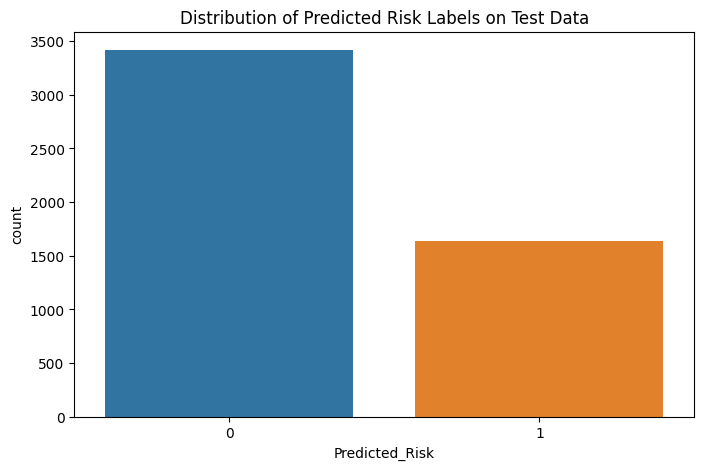

,Tweets,Predicted_Risk
406,want to work at cvs health we re hiring in pom...,0
1397,our colleagues at #cvshealth touch the lives o...,0
1109,make an impact everyday at #cvshealth read abo...,0
2965,eevabee stefanako fishcongen i ve always thoug...,1
3058,dino s cv sky turtle a box weapon of rejuvenat...,1
381,#doral #jobs #hiring #opportunity cvs health r...,0
2255,one person working in the pharmacy now at minu...,0
2546,cvs health corp cvs surprised the market with ...,1
1676,cvs medableinc and cvshealth announced a colla...,0
1039,our community health destinations are engaging...,0


In [19]:
# 1. Convert Predictions to DataFrame
test_data["Predicted_Risk"] = test_predictions

# 2. Visualize Predictions
plt.figure(figsize=(8, 5))
sns.countplot(data=test_data, x='Predicted_Risk')
plt.title("Distribution of Predicted Risk Labels on Test Data")
plt.show()

# 3. Sample Predicted Tweets
sample_predictions = test_data[['Tweets', 'Predicted_Risk']].sample(10)
display(sample_predictions)

### **Output**
## Saving to csv file to be sumitted

In [20]:
# Extract relevant columns
submission_df = test_data[['ID', 'Predicted_Risk']]
submission_df.columns = ['ID', 'Risk Analysis']

# Save to CSV
submission_df.to_csv("submission.csv", index=False)

In [21]:
from sklearn.metrics import f1_score

# Assuming `test_data` has a column called 'Risk Analysis' which is the ground truth
ground_truth = submission_df['Risk Analysis'].values

# Compute F1 score
f1 = f1_score(ground_truth, test_predictions)
print(f"F1 Score: {f1:.4f}")


F1 Score: 1.0000


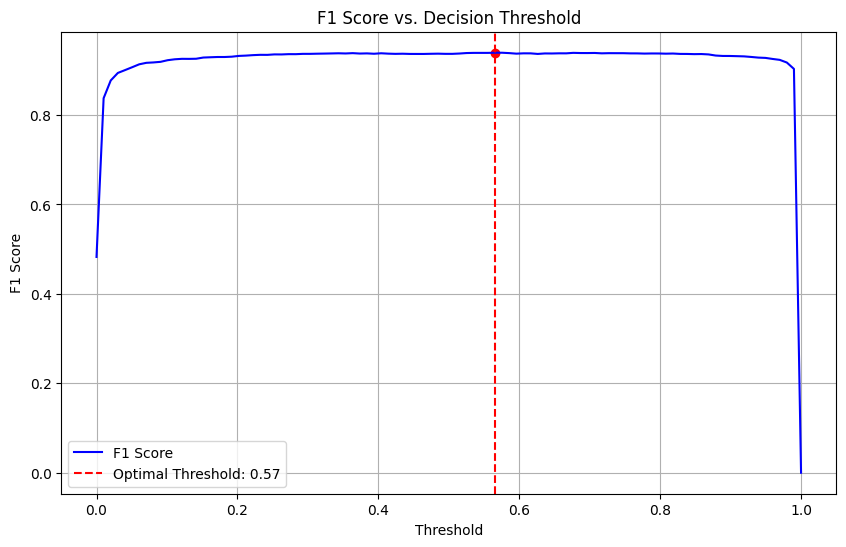

Optimal Threshold: 0.57
Maximum F1 Score: 0.94


In [22]:
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt

y_true, y_pred_probs = [], []

# We'll gather the true labels and predicted probabilities for the validation set
model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=-1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred_probs.extend(probs[:,1].cpu().numpy())

thresholds = np.linspace(0, 1, 100)
f1_scores = []

for threshold in thresholds:
    y_pred = (np.array(y_pred_probs) >= threshold).astype(int)
    f1_scores.append(f1_score(y_true, y_pred))

# Find the optimal threshold
optimal_threshold = thresholds[np.argmax(f1_scores)]
max_f1 = max(f1_scores)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', color='blue')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.2f}')
plt.scatter(optimal_threshold, max_f1, color='red')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Decision Threshold')
plt.legend()
plt.grid(True)
plt.show()

print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Maximum F1 Score: {max_f1:.2f}")


## **Topic Modeling**

Lastly although this is not part of requirements & scope but lets explore **topic modeling techniques**

These implementations should help understand us & review our understanding for extract topics from the tweets dataset using different methods. Each method will give us slightly different topics based on their underlying algorithms, and provide us discretion and analysis to decide which method provides the most interpretable and meaningful topics for this dataset.

### 1. Latent Semantic Analysis (LSA):

LSA uses singular value decomposition (SVD) to decompose the term-document matrix into multiple matrices, capturing the structure of the data and the relationships between words and topics.

Implementation:

Topic #1: cvs, health, corp, pharmacy, job


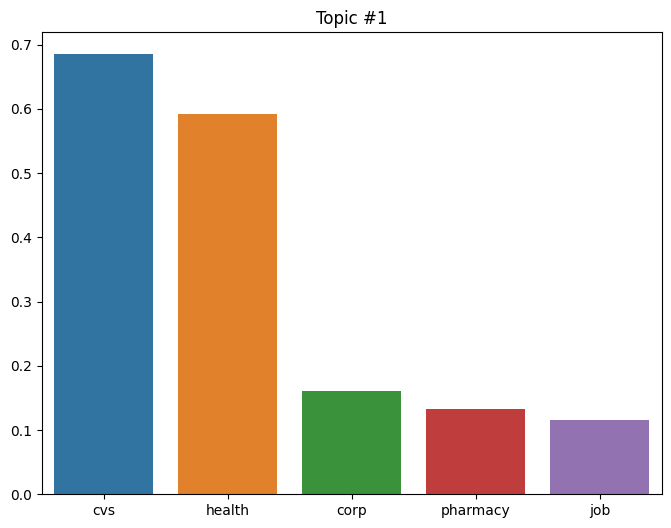

Topic #2: pharmacy, technician, link, bio, job


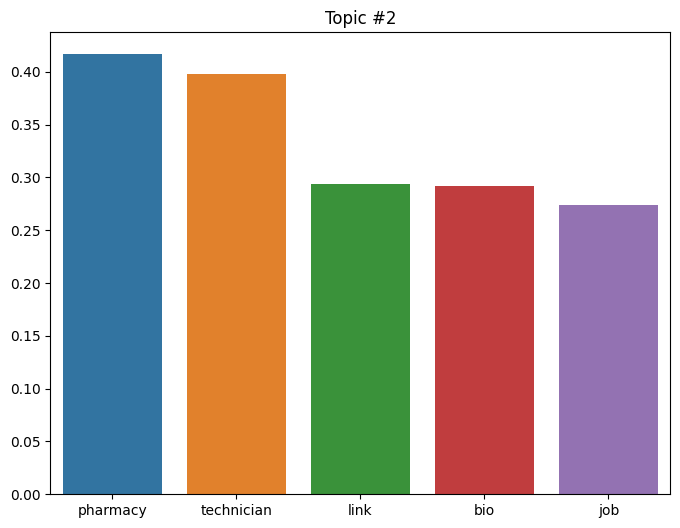

Topic #3: health, cv, cvshealth, amp, care


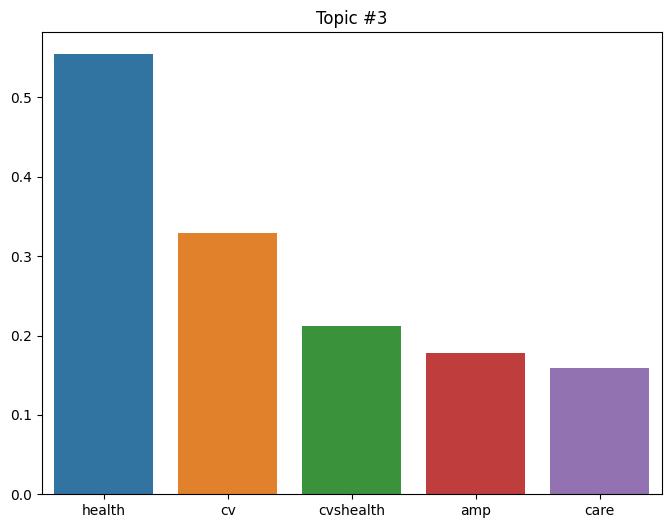

Topic #4: cvshealth, mdbreathe, cvspharmacy, cvs, pharmacy


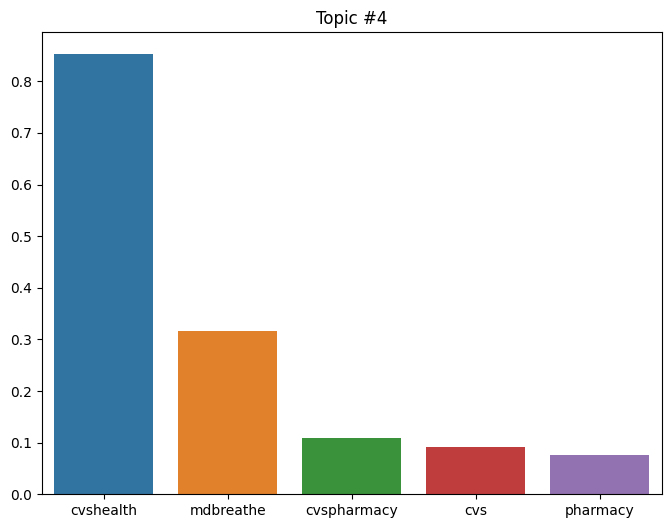

Topic #5: pharmacy, technician, cv, amp, corp


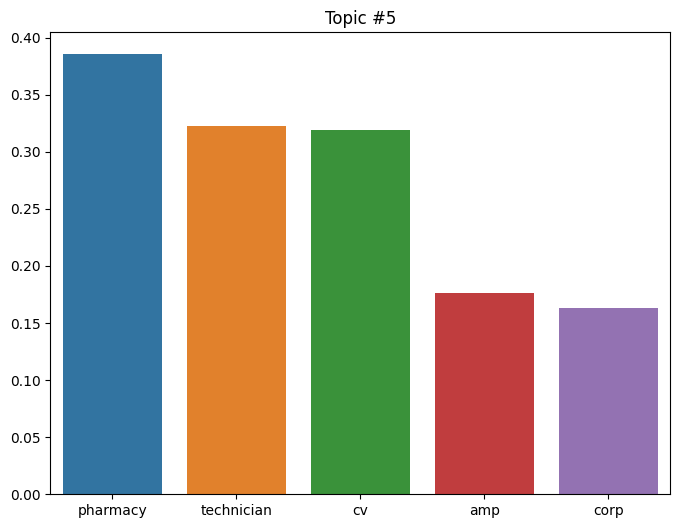

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

# Vectorize the data
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(train_data['cleaned_tweets'])

# Apply LSA
lsa_model = TruncatedSVD(n_components=5, random_state=42)
lsa_topic_matrix = lsa_model.fit_transform(X)

# Getting the top words for each topic
def get_lsa_topics(model, vectorizer, n_words=5):
    terms = vectorizer.get_feature_names_out()
    topic_keywords = []
    for topic_weights in model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(terms.take(top_keyword_locs))
    return topic_keywords

lsa_keywords = get_lsa_topics(lsa_model, vectorizer)

# Convert terms to a list for indexing
terms_list = list(vectorizer.get_feature_names_out())

# Plotting the topics
for index, topic in enumerate(lsa_keywords):
    print(f"Topic #{index + 1}: {', '.join(topic)}")
    plt.figure(figsize=(8, 6))
    sns.barplot(x=topic, y=lsa_model.components_[index][[terms_list.index(i) for i in topic]])
    plt.title(f"Topic #{index + 1}")
    plt.show()


### 2. Probabilistic Latent Semantic Analysis (pLSA):

Unlike LSA, pLSA is a generative model. It models the joint distribution of words and documents and then tries to learn the latent topics based on this distribution.
pLSA is less commonly used in Python due to the lack of pre-built libraries and because LDA (which is discussed below) often outperforms it.

### 3. Latent Dirichlet Allocation (LDA):

LDA is a probabilistic extension of LSA. It assumes that there are K topics shared across a collection of documents. Each document is represented as a distribution over topics, and each topic is conceived as a distribution over words in the documents.

Implementation:

Topic #1: health, cvs, cv, amp, today


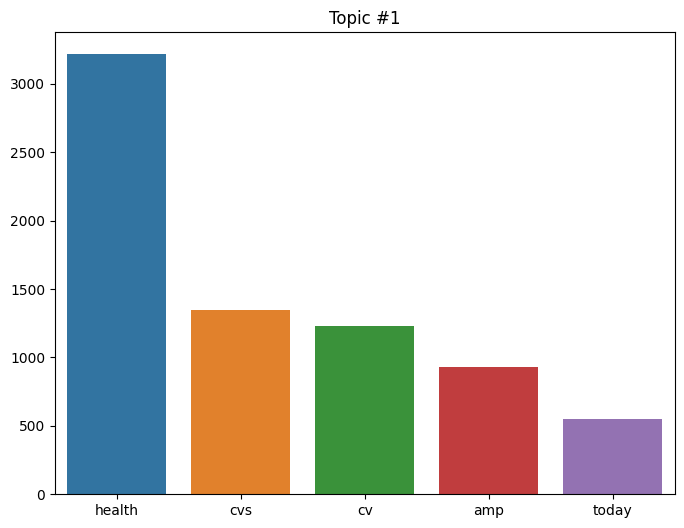

Topic #2: cvshealth, mdbreathe, cvspharmacy, walgreens, don


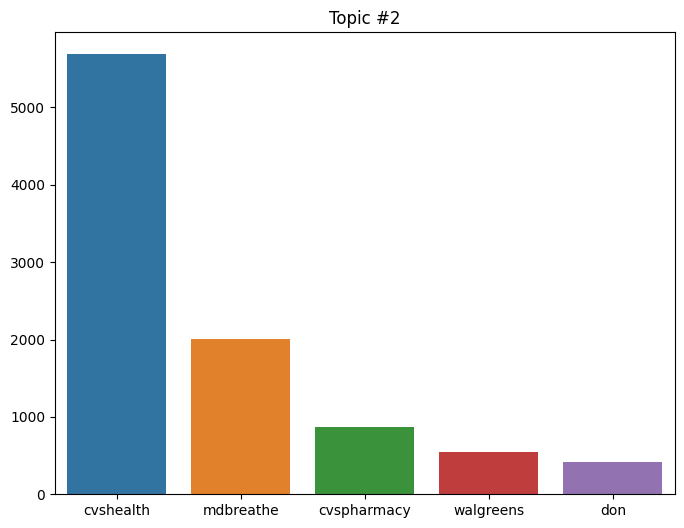

Topic #3: cvs, health, corp, market, rating


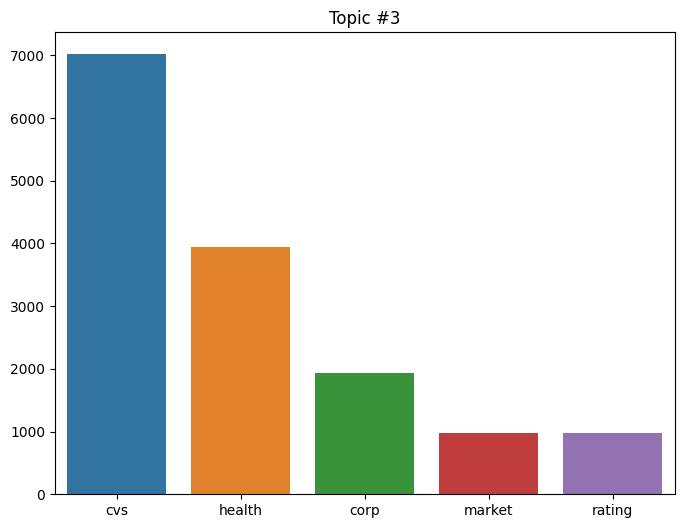

Topic #4: health, cv, cvs, care, amp


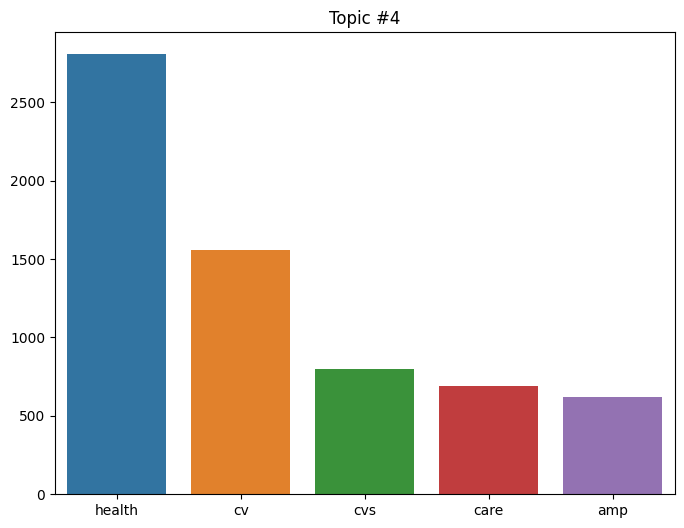

Topic #5: health, cvs, pharmacy, job, technician


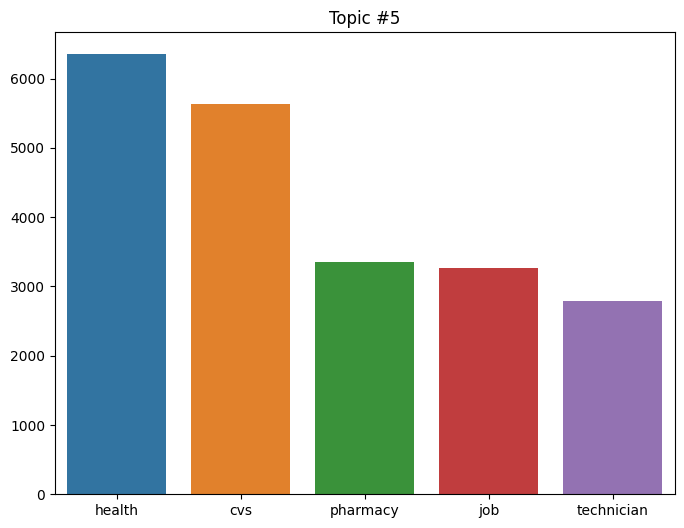

In [24]:
from sklearn.decomposition import LatentDirichletAllocation

# Apply LDA
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_topic_matrix = lda_model.fit_transform(X)

# Getting the top words for each topic
def get_lda_topics(model, vectorizer, n_words=5):
    terms = vectorizer.get_feature_names_out()
    topic_keywords = []
    for topic_weights in model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(terms.take(top_keyword_locs))
    return topic_keywords

lda_keywords = get_lda_topics(lda_model, vectorizer)

# Convert terms to a list for indexing
terms_list = list(vectorizer.get_feature_names_out())

# Plotting the topics
for index, topic in enumerate(lda_keywords):
    print(f"Topic #{index + 1}: {', '.join(topic)}")
    plt.figure(figsize=(8, 6))
    sns.barplot(x=topic, y=lda_model.components_[index][[terms_list.index(i) for i in topic]])
    plt.title(f"Topic #{index + 1}")
    plt.show()


### 4. Non-Negative Matrix Factorization (NMF):

NMF is a dimensionality reduction technique that factorizes non-negative data into non-negative matrices. It's useful for extracting topics from a set of texts.

Implementation:

Topic #1: cvs, health, corp, rating, market


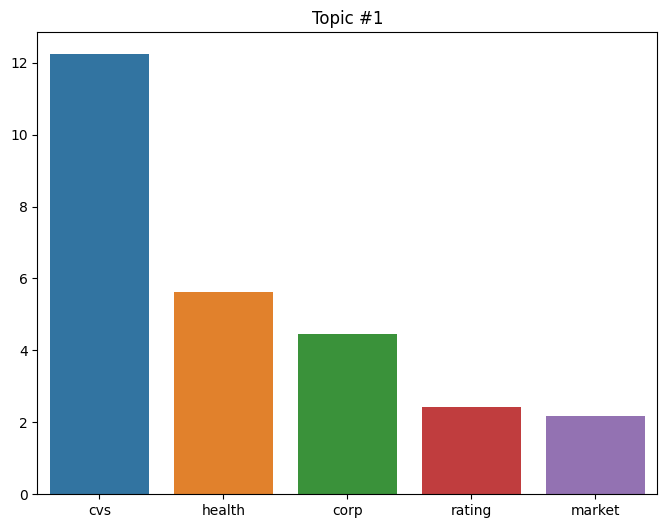

Topic #2: pharmacy, technician, store, retail, bio


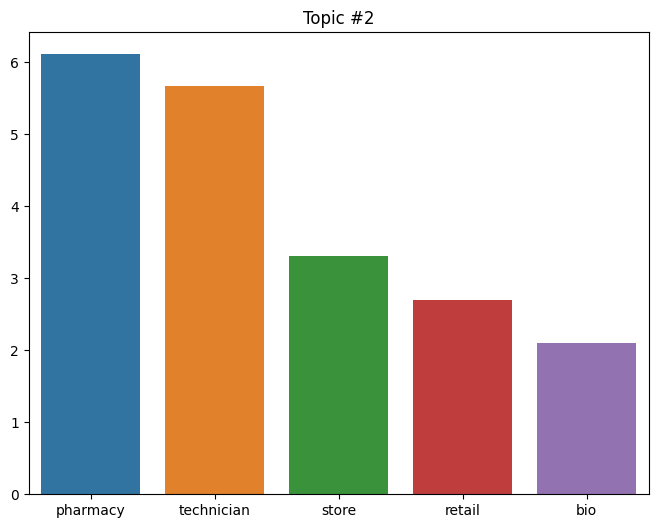

Topic #3: health, cv, care, amp, cvs


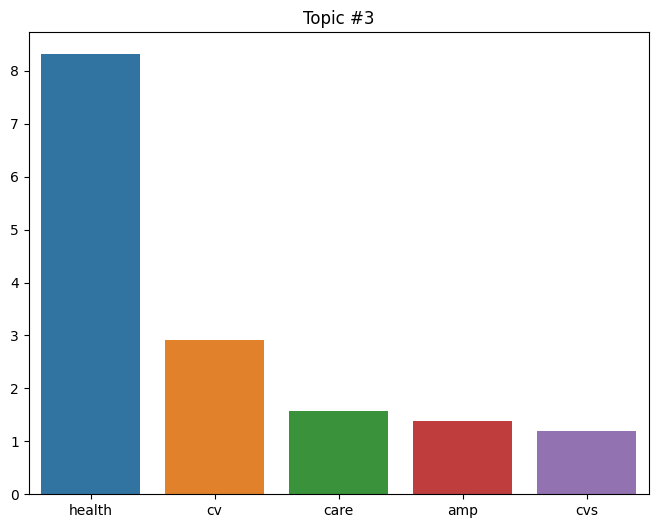

Topic #4: cvshealth, mdbreathe, cvspharmacy, amp, covid


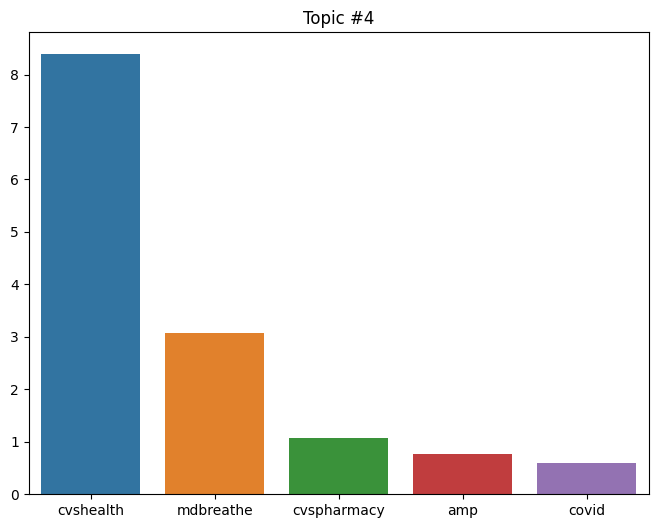

Topic #5: cvs, health, job, link, bio


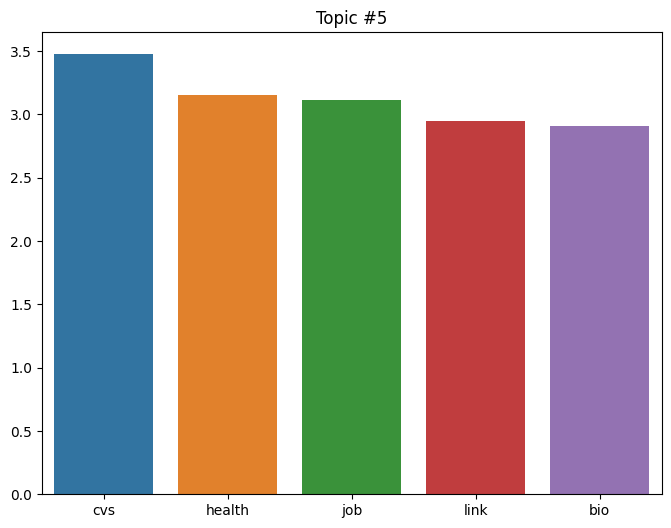

In [25]:
from sklearn.decomposition import NMF

# Apply NMF
nmf_model = NMF(n_components=5, random_state=42)
nmf_topic_matrix = nmf_model.fit_transform(X)

# Getting the top words for each topic
def get_nmf_topics(model, vectorizer, n_words=5):
    terms = vectorizer.get_feature_names_out()
    topic_keywords = []
    for topic_weights in model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(terms.take(top_keyword_locs))
    return topic_keywords

nmf_keywords = get_nmf_topics(nmf_model, vectorizer)

# Convert terms to a list for indexing
terms_list = list(vectorizer.get_feature_names_out())

# Plotting the topics
for index, topic in enumerate(nmf_keywords):
    print(f"Topic #{index + 1}: {', '.join(topic)}")
    plt.figure(figsize=(8, 6))
    sns.barplot(x=topic, y=nmf_model.components_[index][[terms_list.index(i) for i in topic]])
    plt.title(f"Topic #{index + 1}")
    plt.show()


## Vector Database

Although this is totally out of scope, but if time permits I would love to use vector database, if we have high dimesnion / feature handling which is not case for these tweets. But using NLP and nearest neaboug search we can achieve following benefits:

* Semantic Search: To help us fetchign closes document /topic embedding
* Anamoly detecion
* Model training ehancements
* Duplicate detection: similar tweets, articles or topic, then vector database can do the needful efficiently

What would be my steps to create vector database for provided tweets datase:

* Generate embedding: using BERT or RoBERT as above to generate embeddings for provided each tweets in dataset
* Indexing these embedding: Here we supposed to use library e.g. FAISS to create embedding indexes.
* Querying: To check my model decay or future sentimental analysis or risk factorization, give any new set of tweets (or any text), we will generate its embedding and query FAISS index to find similar tweets to get predicted risk